<a href="https://colab.research.google.com/github/karthik-karalgikar/Aedes/blob/main/unet%2B%2B(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
import os
# The path below should point to the directory containing this notebook and the associated utility files
# Change it if necessary
os.chdir('/content/gdrive/MyDrive')
PATH='./'

In [6]:
#Step 1: Load libraries for the U-net Model

import skimage.io as io
import skimage.transform as trans
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf

In [7]:
#Step 2: Import the U-net model
from model_new import *
img_size=(256,256)

In [8]:
n_class=2

In [9]:
mod = Nest_Net(img_size[0],img_size[1],1,1,deep_supervision=True)

In [10]:
#Step 3:Define functions for pre-processing data
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import scipy.misc as sc


def adjustData(img,mask,flag_multi_class,n_class):

    if(flag_multi_class):
        img /= 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (n_class,))
        for i in range(n_class):

            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img)>1):
        img = img / 255
        mask = mask /255
    mask[mask > 0.5] = 1
    mask[mask <=0.5] = 0
        #print(np.shape(mask),np.shape(img))
    return (img,mask)

def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,n_class = n_class,save_to_dir = None,target_size = img_size,seed = 1):
    '''
    can generate image and mask at the same time
    use the same seed for image_datagen and mask_datagen to ensure the transformation for image and mask is the same
    if you want to visualize the results of generator, set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        #'./',
        train_path,
        classes = [image_folder],
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        class_mode=None,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        class_mode=None,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,n_class)
        yield (img,mask)

def testGenerator(test_path,target_size = img_size,flag_multi_class = True,as_gray = True):
    files=sorted(os.listdir(test_path))
    num_image=len(files)
    for i in range(num_image):
        img = io.imread(os.path.join(test_path,files[i]),as_gray = as_gray)
        print(files[i])
        img = trans.resize(img,target_size)
        img = np.reshape(img,img.shape+(1,)) if (not flag_multi_class) else img
        img = np.reshape(img,(1,)+img.shape)
        #print(np.max(img))
        yield img


In [11]:
#Step 4: Define function to save the test images
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i] = color_dict[i]

    return img_out


def saveResult(img_path, save_path, npyfile, flag_multi_class=False, num_class=2):
    files = [f for f in sorted(os.listdir(img_path)) if f.endswith(('.png', '.jpg', '.jpeg'))]  # Filter only image files
    if len(files) != len(npyfile):
        print("Warning: Mismatch in number of files and predictions.")
        return

    for i, item in enumerate(npyfile):
        if flag_multi_class:
            img = labelVisualize(num_class, COLOR_DICT, item)
        else:
            img = np.squeeze(item)  # Assuming item has shape (H, W, 1)
            if img.ndim == 2:
                img = gray2rgb(img)  # Convert grayscale to RGB if necessary

        # Normalize and binarize the image
        img = img_as_ubyte(img > 0.5)

        file_path = os.path.join(save_path, files[i])
        io.imsave(file_path, img)
        print(f"Saved: {file_path}")

def SaveResultwImage(img_path,save_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=os.listdir(img_path)
    #print(len(img_path))
    #print(len(npyfile))

    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
        #img1=np.array(((img - np.min(img))/np.ptp(img))>0.6).astype(float)
        img[img>0.2]=1
        img[img<=0.2]=0

        I = io.imread(os.path.join(img_path,files[i]), as_gray=True)
        I = trans.resize(I,target_size)
        #dst = cv2.addWeighted(img, 0.5, I, 0.5, 0.0)
        img=np.true_divide((I+img),2)
        io.imsave(os.path.join(save_path, files[i]),img)

In [12]:
#Step 5: Define functions to evaluate the output
import sklearn.metrics as sm

def get_confusion_matrix_elements(groundtruth_list, predicted_list):
    """returns confusion matrix elements i.e TN, FP, FN, TP as floats
	See example code for helper function definitions
    """
    tn, fp, fn, tp = sm.confusion_matrix(groundtruth_list, predicted_list,labels=[0,1]).ravel()
    tn, fp, fn, tp = np.float64(tn), np.float64(fp), np.float64(fn), np.float64(tp)

    return tn, fp, fn, tp

def get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list):
    """returns precision, recall, IoU and accuracy metrics
	"""
    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    total = tp + fp + fn + tn
    accuracy = (tp + tn) / total
    prec=tp/(tp+fp)
    rec=tp/(tp+fn)
    IoU=tp/(tp+fp+fn)

    return prec,rec,IoU,accuracy

def get_f1_score(groundtruth_list, predicted_list):
    """Return f1 score covering edge cases"""

    tn, fp, fn, tp = get_confusion_matrix_elements(groundtruth_list, predicted_list)

    f1_score = (2 * tp) / ((2 * tp) + fp + fn)

    return f1_score

def get_validation_metrics(groundtruth,predicted):
    """Return all output metrics. Input is binary images"""

    u,v=np.shape(groundtruth)
    groundtruth_list=np.reshape(groundtruth,(u*v,))
    predicted_list=np.reshape(predicted,(u*v,))
    prec,rec,IoU,acc=get_prec_rec_IoU_accuracy(groundtruth_list, predicted_list)
    f1_score=get_f1_score(groundtruth_list, predicted_list)
   # print("Precision=",prec, "Recall=",rec, "IoU=",IoU, "acc=",acc, "F1=",f1_score)
    return prec,rec,IoU,acc,f1_score

def evalResult(gth_path,npyfile,target_size=img_size,flag_multi_class = False,num_class = 2):
    files=sorted(os.listdir(gth_path))
    #print(files)
    prec=0
    rec=0
    acc=0
    IoU=0
    f1_score=0
    for i,item in enumerate(npyfile):
        img = item[:,:,0]
        gth = io.imread(os.path.join(gth_path,files[i]))
        gth = trans.resize(gth,target_size)
        if(np.sum(img)>0):
            img=np.array(((img - np.min(img))/np.ptp(img))>0.1).astype(float)
        if(np.sum(gth)>0):
            gth=np.array(((gth - np.min(gth))/np.ptp(gth))>0.1).astype(float)
            gth=(gth>0.1).astype(int)
        #print(np.shape(gth),np.shape(img))
        p,r,I,a,f=get_validation_metrics(gth[:,:,1],img)
        if (np.isnan(p)):
          p=1
        if (np.isnan(r)):
          r=1
        if (np.isnan(f)):
          f=1
        if (np.isnan(I)):
          I=1
        prec=prec+p
        rec=rec+r
        acc=acc+a
        IoU=IoU+I
        f1_score=f1_score+f
    print("Precision=",prec/(i+1), "Recall=",rec/(i+1), "Jac=",IoU/(i+1), "acc=",acc/(i+1), "Dice=",f1_score/(i+1))


In [13]:
data_gen_args = dict(rotation_range=0.2,
                     #rescale=1./255,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.1,
                    zoom_range=[0.8,1],
                    horizontal_flip=True,
                    vertical_flip=True,
                    fill_mode='nearest')
PATH='./train/'

In [14]:
data_gen = trainGenerator(3,PATH,'MainDataset','Masked_images',data_gen_args, save_to_dir = None)

In [15]:
mod.compile(optimizer = Adam(learning_rate=0.0003), loss = dice_coef_loss, metrics = dice_coef)

In [17]:
hist = mod.fit(data_gen,steps_per_epoch=10,epochs=20,verbose=1)

Epoch 1/20
10/10 [==============================] - 199s 18s/step - loss: -1.0737 - output_1_loss: -0.2467 - output_2_loss: -0.2724 - output_3_loss: -0.2775 - output_4_loss: -0.2772 - output_1_dice_coef: 0.2467 - output_2_dice_coef: 0.2724 - output_3_dice_coef: 0.2775 - output_4_dice_coef: 0.2772
Epoch 2/20
10/10 [==============================] - 193s 19s/step - loss: -1.0168 - output_1_loss: -0.2389 - output_2_loss: -0.2567 - output_3_loss: -0.2620 - output_4_loss: -0.2592 - output_1_dice_coef: 0.2389 - output_2_dice_coef: 0.2567 - output_3_dice_coef: 0.2620 - output_4_dice_coef: 0.2592
Epoch 3/20
10/10 [==============================] - 204s 20s/step - loss: -1.1894 - output_1_loss: -0.2726 - output_2_loss: -0.3056 - output_3_loss: -0.3052 - output_4_loss: -0.3060 - output_1_dice_coef: 0.2726 - output_2_dice_coef: 0.3056 - output_3_dice_coef: 0.3052 - output_4_dice_coef: 0.3060
Epoch 4/20
10/10 [==============================] - 200s 20s/step - loss: -0.7401 - output_1_loss: -0.1718

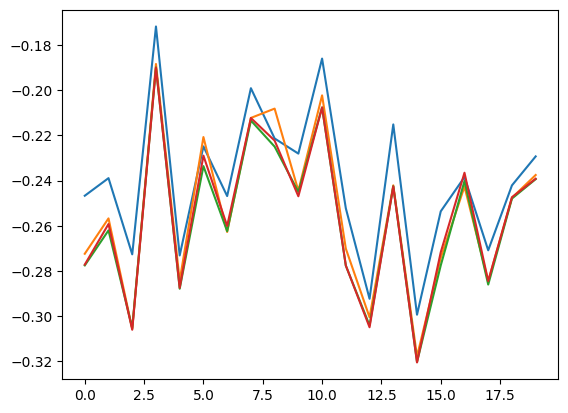

In [18]:
plt.plot(hist.history['output_1_loss'])
plt.plot(hist.history['output_2_loss'])
plt.plot(hist.history['output_3_loss'])
plt.plot(hist.history['output_4_loss'])

In [19]:
#Step 1: Run model on test images and save the images
#number of test images
n_i=len(os.listdir('./test/MainDataset/'))
#Call test generator
test_gen= testGenerator('./test/MainDataset/')
print(n_i)

407


In [20]:
#Return model outcome for each test image
results = mod.predict_generator(test_gen,n_i,verbose=1)

<ipython-input-20-ea1ab214b1d0>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  results = mod.predict_generator(test_gen,n_i,verbose=1)


aedes (103).jpg
aedes (104).jpg
  1/407 [..............................] - ETA: 15:56aedes (105).jpg
aedes (106).jpg
  4/407 [..............................] - ETA: 14:56aedes (107).jpg
aedes (108).jpg
aedes (109).jpg
  7/407 [..............................] - ETA: 15:54aedes (11).jpg
aedes (110).jpg
aedes (111).jpg
aedes (113).jpg
  8/407 [..............................] - ETA: 16:39aedes (114).jpg
aedes (116).jpg
aedes (117).jpg
407/407 [==============================] - 633s 2s/step


In [21]:
saveResult('./test/MainDataset/','./pred/',results)

In [22]:
np.shape(results)

(4, 407, 256, 256, 1)

1.0 1.7055878e-13


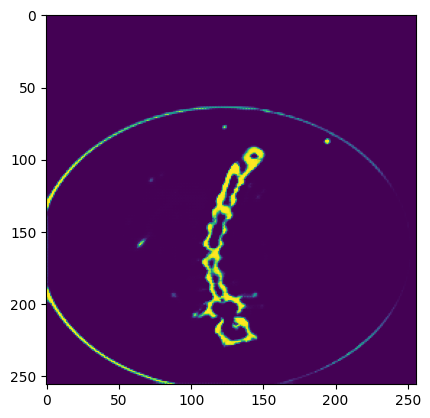

In [23]:
#Lets visualize the STARE predictions
plt.imshow(results[0][50][:,:,0])
print(np.max(results[0]),np.min(results[0]))

In [27]:
def return_Unet_result_layers(files,img_path, results,num):
  I=io.imread(os.path.join(img_path,files[num]), as_gray=True)
  I = trans.resize(I,img_size)
  pred0=(results[0][num][:,:,0]>0.5).astype(int)
  pred1=(results[1][num][:,:,0]>0.5).astype(int)
  pred2=(results[2][num][:,:,0]>0.5).astype(int)
  pred3=(results[3][num][:,:,0]>0.5).astype(int)
  f, axarr = plt.subplots(2,2)
  axarr[0,0].imshow(np.true_divide((I+pred0),2))
  axarr[0,1].imshow(np.true_divide((I+pred1),2))
  axarr[1,0].imshow(np.true_divide((I+pred2),2))
  axarr[1,1].imshow(np.true_divide((I+pred3),2))
  return pred2,pred3

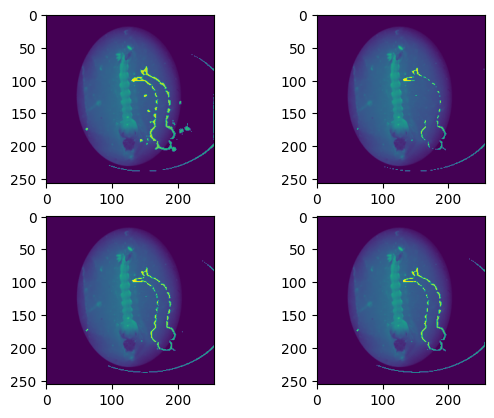

In [28]:
pred2,pred3=return_Unet_result_layers(os.listdir('./test/MainDataset/'),'./test/MainDataset/',results,20)

In [29]:
get_validation_metrics(pred3,pred2)

(0.9036402569593148,
 0.9154013015184381,
 0.83399209486166,
 0.9974365234375,
 0.9094827586206896)

In [30]:
evalResult('./test/Masked_images/',results)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed